# LA's COVID-19 Reopening Indicators 

This report contains information about how LA is preformed, compared to yesterday, on a number of key COVID indicators related to the speed at which opening up can occur.  
    
* [Federal Gating Criteria](https://www.whitehouse.gov/wp-content/uploads/2020/04/Guidelines-for-Opening-Up-America-Again.pdf)
* [State Gating Criteria](https://covid19.ca.gov/roadmap-counties/)

Below, you will see how LA is doing compared to yesterday on the follow indicators. 

#### Symptoms
* Downward trajectory of influenza-like illnesses (ILI) reported within a 14-day period **and**
* Downward trajectory of COVID-like syndromic cases reported within a 14-day period

#### Cases
* Downward trajectory of documented cases within a 14-day period **or**
* Downward trajectory of positive tests as a percent of total tests within a 14-day period (flat or increasing volume of tests) 

#### Hospitals
* Treat all patients without crisis care **and**
* Robust testing program in place for at-risk healthcare workers, including emerging antibody testing

### References
* [Reopening Indicators](https://github.com/CityOfLosAngeles/covid19-indicators/blob/master/references/Reopening_Indicators_Comparison.xlsx) from [New York State](https://www.nytimes.com/2020/05/04/nyregion/coronavirus-reopen-cuomo-ny.html) and [Chicago](https://www.chicagotribune.com/coronavirus/ct-coronavirus-chicago-reopening-lightfoot-20200508-ztpnouwexrcvfdfcr2yccbc53a-story.html)
* [Collection of articles](https://github.com/CityOfLosAngeles/covid19-indicators/blob/master/reopening-sources.md) related to what experts say about reopening and the known unknowns ahead 
    * [LA and Chicago](https://www.nytimes.com/2020/05/09/us/coronavirus-chicago.html), after NYC, have the most persistent virus caseloads
    * [LA, DC, and Chicago](https://www.latimes.com/california/story/2020-05-22/white-house-concerned-with-coronavirus-spread-in-l-a-area-asks-cdc-to-investigate) remain hotspots within the US

In [1]:
import altair as alt
import pandas as pd
import pytz

import utils
import meet_indicators
import default_parameters

from datetime import date, datetime, timedelta
from IPython.display import Markdown

# Default parameters
county_state_name = default_parameters.county_state_name
state_name = default_parameters.state_name
msa_name = default_parameters.msa_name
time_zone = default_parameters.time_zone

fulldate_format = default_parameters.fulldate_format
monthdate_format = default_parameters.monthdate_format
start_date = default_parameters.start_date
yesterday_date = default_parameters.yesterday_date
today_date = default_parameters.today_date
two_weeks_ago = default_parameters.two_weeks_ago
two_days_ago = default_parameters.two_days_ago

# Daily testing upper and lower bound
county_test_lower_bound = 15_000
county_test_upper_bound = 16_667
city_test_lower_bound = round(county_test_lower_bound * 0.5)
city_test_upper_bound = round(county_test_upper_bound * 0.5)
positive_lower_bound = 0.04
positive_upper_bound = 0.08
hospital_bound = 0.30

In [2]:
def check_report_readiness(county_state_name, state_name, msa_name, start_date, yesterday_date):
    """
    Check if each dataframe has yesterday's date's info.
    If all datasets are complete, report can be run.
    """
    
    df = utils.prep_county(county_state_name, start_date)
    if df.date2.max() < yesterday_date:
        raise Exception("Data incomplete")    
    
    df = utils.prep_lacity_cases(start_date)
    if df.date2.max() < yesterday_date:
        raise Exception("Data incomplete")        
    
    df = utils.prep_testing(start_date)
    if df.date2.max() < yesterday_date:
        raise Exception("Data incomplete")        
    
    df = utils.prep_lacounty_hospital(start_date)
    if df.date2.max() <  yesterday_date:
        raise Exception("Data incomplete") 
        
check_report_readiness(county_state_name, state_name, msa_name, start_date, yesterday_date)

In [3]:
def summary_of_lacounty_indicators():    
    county_case_indicator = meet_indicators.meet_case("county", county_state_name, start_date)
    county_death_indicator = meet_indicators.meet_death("county", county_state_name, start_date)
    county_test_indicator = meet_indicators.meet_daily_testing(yesterday_date, "county", 
                                                               county_test_lower_bound, county_test_upper_bound)
    county_positive_indicator = meet_indicators.meet_positive_share(yesterday_date, "county", 
                                                                    positive_lower_bound, positive_upper_bound)
    acute_indicator = meet_indicators.meet_acute(yesterday_date)
    icu_indicator = meet_indicators.meet_icu(yesterday_date)
    ventilator_indicator = meet_indicators.meet_ventilator(yesterday_date)
    
    # Markdown output
    display(Markdown(f"### Summary of LA County Indicators as of {yesterday_date}:"))
    display(Markdown("#### Cases")) 
    display(Markdown("<i>Cases and deaths should sustain a 14-day downward trajectory.</i>"))
  
    # Cases
    display(Markdown(f"Declining cases: **{county_case_indicator}** out of 14 days"))
    display(Markdown(f"Declining deaths: **{county_death_indicator}** out of 14 days"))
   
    display(Markdown("#### Testing"))
    display(Markdown("<i>Testing values can be <span style='color:red'>below lower bound; </span><span style='color:green'>between lower and upper bound; </span><span style = 'color:blue'>above upper bound</span></i>"))    
    display(Markdown("<i>Positive share values can be <span style='color:red'>above upper bound; </span><span style='color:green'>between lower and upper bound; </span><span style = 'color:blue'>below lower bound</span></i>")) 
        
    # Daily Testing
    if county_test_indicator >= county_test_upper_bound:
        display(Markdown(f"Daily Testing: <strong><span style='color:blue'>{county_test_indicator:,}</span></strong>"))    
    if (county_test_indicator >= county_test_lower_bound) and (county_test_indicator < county_test_upper_bound):
        display(Markdown(f"Daily Testing: <strong><span style='color:green'>{county_test_indicator:,}</span></strong>"))
    if county_test_indicator < county_test_lower_bound:
        display(Markdown(f"Daily Testing: <strong><span style='color:red'>{county_test_indicator:,}</span></strong>"))          

    # Share of Positive Tests
    if county_positive_indicator > positive_upper_bound:
        display(Markdown(f"Share of Positive COVID-19 Results: <strong><span style='color:red'>{county_positive_indicator}</span></strong>"))          
    if (county_positive_indicator >= positive_lower_bound) and (county_positive_indicator < positive_upper_bound):
        display(Markdown(f"Share of Positive COVID-19 Results: <strong><span style='color:green'>{county_positive_indicator}</span></strong>"))          
    if county_positive_indicator < positive_lower_bound:
        display(Markdown(f"Share of Positive COVID-19 Results: <strong><span style='color:blue'>{county_positive_indicator}</span></strong>"))   
    
    display(Markdown("#### Hospital Equipment"))  
    display(Markdown("<i>Available hospital equipment can be <span style='color:red'>below 30%; </span><span style='color:green'>above 30%</span></i>"))    

    # Hospital Equipment
    if acute_indicator >= hospital_bound:
        display(Markdown(f"% Acute Beds: <strong><span style='color:green'>{acute_indicator}</span></strong>"))          
    elif acute_indicator < hospital_bound:
        display(Markdown(f"% Acute Beds: <strong><span style='color:red'>{acute_indicator}</span></strong>"))          

    if icu_indicator >= hospital_bound:
        display(Markdown(f"% ICU Beds: <strong><span style='color:green'>{icu_indicator}</span></strong>"))          
    elif icu_indicator < hospital_bound:
        display(Markdown(f"% ICU Beds: <strong><span style='color:red'>{icu_indicator}</span></strong>")) 
    
    if ventilator_indicator >= hospital_bound:
        display(Markdown(f"% Ventilators: <strong><span style='color:green'>{ventilator_indicator}</span></strong>"))          
    elif ventilator_indicator < hospital_bound:
        display(Markdown(f"% Ventilators: <strong><span style='color:red'>{ventilator_indicator}</span></strong>")) 

In [4]:
def summary_of_lacity_indicators():    
    city_case_indicator = meet_indicators.meet_lacity_case(start_date)
    city_test_indicator = meet_indicators.meet_daily_testing(yesterday_date, "city", 
                                                                   city_test_lower_bound, city_test_upper_bound)
    city_positive_indicator = meet_indicators.meet_positive_share(yesterday_date, "city", 
                                                                  positive_lower_bound, positive_upper_bound)
    
    # Markdown output
    display(Markdown(f"### Summary of City of LA Indicators as of {yesterday_date}:"))
    display(Markdown("#### Cases")) 
    display(Markdown("<i>Cases and deaths should sustain a 14-day downward trajectory</i>"))

    # Cases
    display(Markdown(f"Declining cases: **{city_case_indicator}** out of 14 days"))

    display(Markdown("#### Testing"))
    display(Markdown("<i>Testing values can be <span style='color:red'>below lower bound; </span><span style='color:green'>between lower and upper bound; </span><span style = 'color:blue'>above upper bound</span></i>"))    
    display(Markdown("<i>Positive share values can be <span style='color:red'>above upper bound; </span><span style='color:green'>between lower and upper bound; </span><span style = 'color:blue'>below lower bound</span></i>")) 
    
    # Daily Testing
    if city_test_indicator >= city_test_upper_bound:
        display(Markdown(f"Daily Testing: <strong><span style='color:blue'>{city_test_indicator:,}</span></strong>"))    
    if (city_test_indicator >= city_test_lower_bound) and (city_test_indicator < city_test_upper_bound):
        display(Markdown(f"Daily Testing: <strong><span style='color:green'>{city_test_indicator:,}</span></strong>"))
    if city_test_indicator < city_test_lower_bound:
        display(Markdown(f"Daily Testing: <strong><span style='color:red'>{city_test_indicator:,}</span></strong>"))          
    
    # Share of Positive Tests
    if city_positive_indicator > positive_upper_bound:
        display(Markdown(f"Share of Positive COVID-19 Results: <strong><span style='color:red'>{city_positive_indicator}</span></strong>"))          
    if (city_positive_indicator >= positive_lower_bound) and (city_positive_indicator < positive_upper_bound):
        display(Markdown(f"Share of Positive COVID-19 Results: <strong><span style='color:green'>{city_positive_indicator}</span></strong>"))          
    if city_positive_indicator < positive_lower_bound:
        display(Markdown(f"Share of Positive COVID-19 Results: <strong><span style='color:blue'>{city_positive_indicator}</span></strong>"))       
   

In [5]:
summary_of_lacounty_indicators()
summary_of_lacity_indicators()

### Summary of LA County Indicators as of 6/2/20:

#### Cases

<i>Cases and deaths should sustain a 14-day downward trajectory.</i>

Declining cases: **4** out of 14 days

Declining deaths: **8** out of 14 days

#### Testing

<i>Testing values can be <span style='color:red'>below lower bound; </span><span style='color:green'>between lower and upper bound; </span><span style = 'color:blue'>above upper bound</span></i>

<i>Positive share values can be <span style='color:red'>above upper bound; </span><span style='color:green'>between lower and upper bound; </span><span style = 'color:blue'>below lower bound</span></i>

Daily Testing: <strong><span style='color:red'>6,269</span></strong>

Share of Positive COVID-19 Results: <strong><span style='color:red'>0.12</span></strong>

#### Hospital Equipment

<i>Available hospital equipment can be <span style='color:red'>below 30%; </span><span style='color:green'>above 30%</span></i>

% Acute Beds: <strong><span style='color:red'>0.2</span></strong>

% ICU Beds: <strong><span style='color:red'>0.15</span></strong>

% Ventilators: <strong><span style='color:green'>0.55</span></strong>

### Summary of City of LA Indicators as of 6/2/20:

#### Cases

<i>Cases and deaths should sustain a 14-day downward trajectory</i>

Declining cases: **4** out of 14 days

#### Testing

<i>Testing values can be <span style='color:red'>below lower bound; </span><span style='color:green'>between lower and upper bound; </span><span style = 'color:blue'>above upper bound</span></i>

<i>Positive share values can be <span style='color:red'>above upper bound; </span><span style='color:green'>between lower and upper bound; </span><span style = 'color:blue'>below lower bound</span></i>

Daily Testing: <strong><span style='color:red'>118</span></strong>

Share of Positive COVID-19 Results: <strong><span style='color:red'>0.1</span></strong>

## Caseload Charts

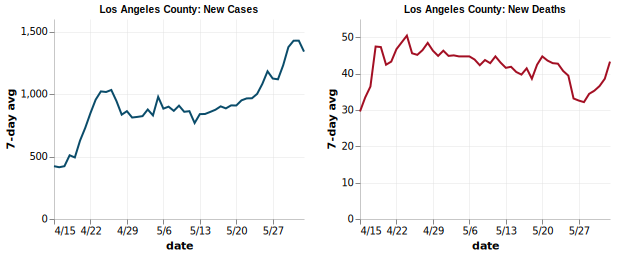

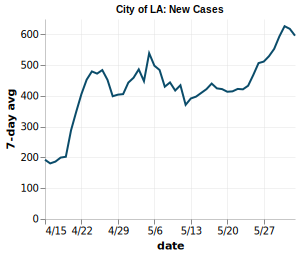

In [6]:
la_county = utils.county_case_charts(county_state_name, start_date)
la_city = utils.lacity_case_charts(start_date) 

## Testing Charts

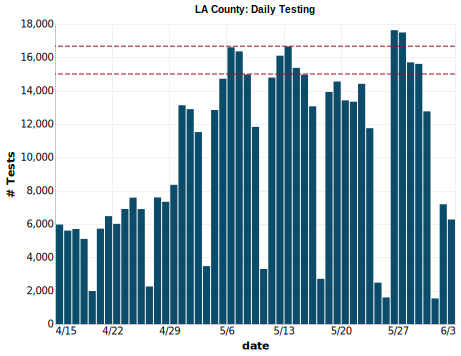

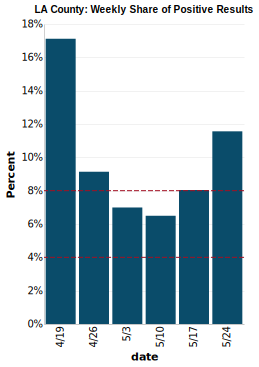

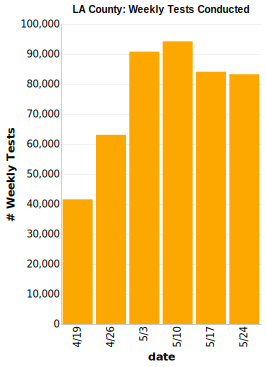

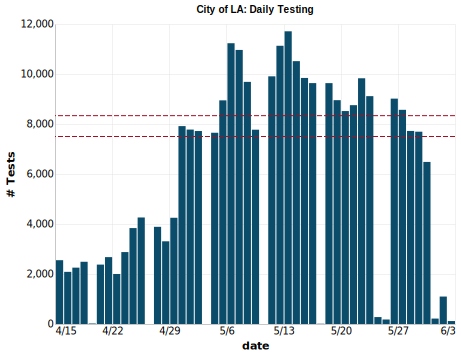

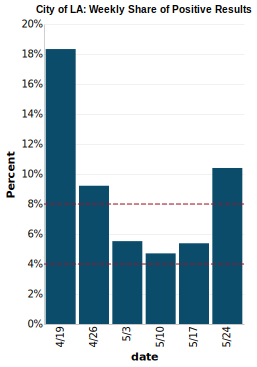

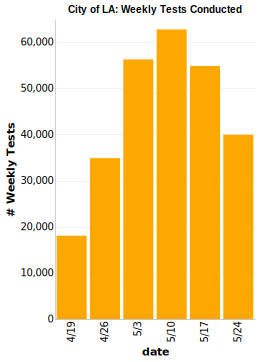

In [7]:
county_tests = utils.lacounty_testing_charts(start_date, county_test_lower_bound, county_test_upper_bound)
positive_tests = utils.lacounty_positive_test_charts(start_date, positive_lower_bound, positive_upper_bound)
city_tests = utils.lacity_testing_charts(start_date, city_test_lower_bound, city_test_upper_bound)
positive_tests = utils.lacity_positive_test_charts(start_date, positive_lower_bound, positive_upper_bound)

## Hospital Capacity Charts

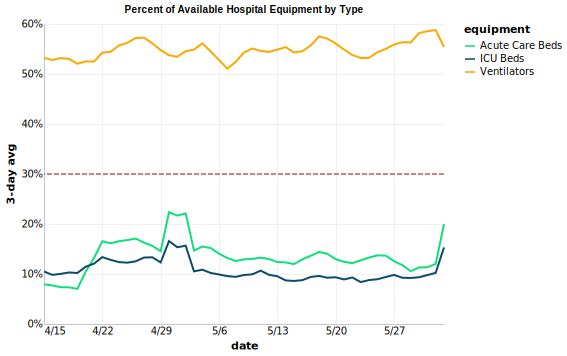

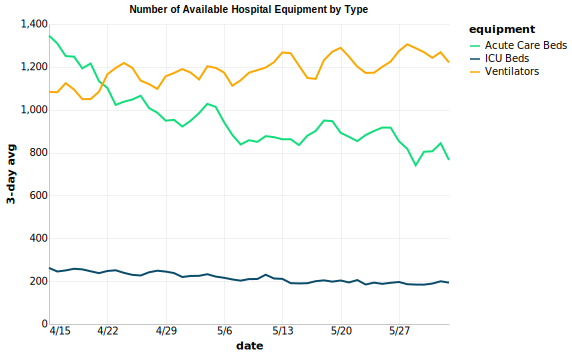

In [8]:
hospital = utils.lacounty_hospital_charts(start_date)

If you have any questions, please email ITAData@lacity.org. 